In [239]:
import numpy as np
from numpy.random import multivariate_normal as mvn

import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize

from math import log
from math import dist
from math import floor
from math import pi

from random import shuffle

from tqdm import tqdm

from weights import KNN
from weights import proximity

from accuracy import KNN_acc
from accuracy import Prox_acc

from points import spiralPoints

# Complete Spiral Example

## Generating the Points

We first write a function to generate three well-separated clusters, depending on the number of points desired and the centers and covariance matrix of the distributions

In [358]:
def clusters(m, tranges, var):
	# m is the number of points

	knownvals = [int(j*int(m/8)) for j in range(8)] # Points for which we know the value of the label

	X = spiralPoints(int(m/2), tranges[0,0], tranges[0,1], var)
	X = np.append(X, spiralPoints(int(m/4), tranges[1,0], tranges[1,1], var), axis=0)
	X = np.append(X, spiralPoints(int(m/4), tranges[2,0], tranges[2,1], var), axis=0)

	y = [1 for i in range(int(m/2))]
	y = y + [-1 for i in range(int(m/2))]

	return X, y, knownvals

We use this to generate the points

In [328]:
M = 400 # Multiple of 4

tranges = np.array([[pi,5*pi/2], [3*pi,7*pi/2], [4*pi,9*pi/2]])
var = 1

X, y, knownvals = clusters(M, tranges, var)

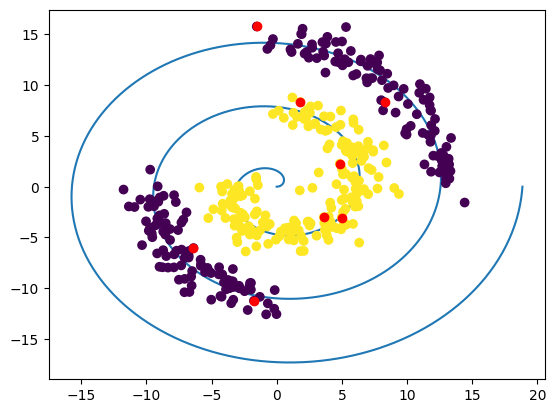

In [329]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

ts = np.linspace(0, 6*pi,1000)
plt.plot(ts*np.cos(ts), ts*np.sin(ts), zorder = -1)

plt.scatter(xs, ys, c=y, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

## Build a Graph on the Points and Run Regression

To build a graph on the points, we have some choices to make: the choice of weight function and its parameters and whether we use a KNN approach or a full proximity graph approach

Here is an example of some of these graphs

### KNN with uniform kernel

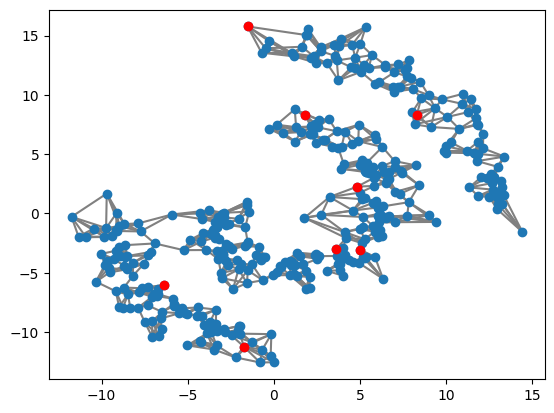

In [330]:
unif = lambda x1, x2: 1
k = 5

L, W = KNN(X, M, k, unif)

plt.scatter(xs, ys)
plt.scatter(xs_k, ys_k, color="red")

for i in range(M):
	for j in range(i,M):
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = "gray", zorder = 0)

Performing the classification, we see that the model performs well with both probit and regression loss. Note that it was not necessary to tune parameters to get good results.

In [331]:
def probit(kvals, y, f): # Probits Loss
	return -sum([log(norm.cdf(y[j]*f[j])) for j in kvals])

def regression(kvals, y, f): # Regression Loss
	return sum([(y[j]-f[j])**2 for j in kvals])

def regular(lamb,C_inv,f): # Regularization
	f_T = np.array(f).T
	return lamb*f_T.dot(C_inv).dot(f)

def to_minimize(f,kvals,y,lamb,C_inv, loss): # Funtional to minimize
    return loss(kvals,y,f) + regular(lamb,C_inv,f)

In [332]:
tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
C_inv = np.linalg.inv(C)

#### Probit Loss

In [333]:
loss = probit

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

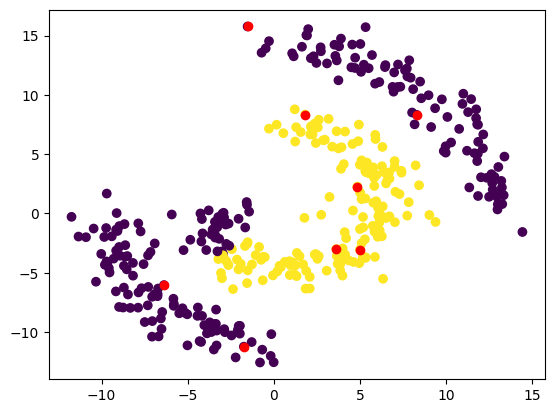

In [334]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [335]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

0.91


#### Regression Loss

In [336]:
loss = regression

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

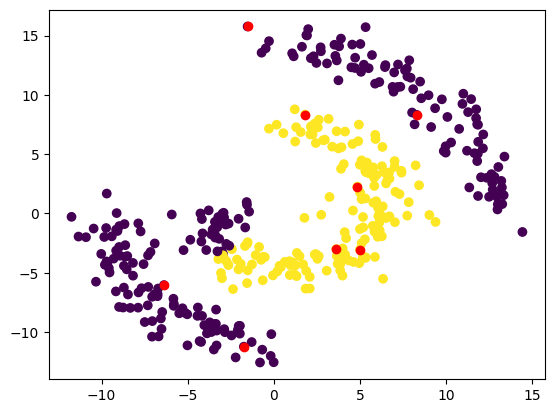

In [337]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [338]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

0.91


### KNN with RBF Kernel

We can see that KNN with the uniform kernel is not particularly effective for this scenario. Let's see if we can fix this problem with the RBF kernel

We first need to make a guess at the gamma parameter in the RBF kernel. We use the first quartile of the distances between vertices. Then we adjust using our multplier

In [339]:
dists = []
for x1 in X:
	for x2 in X:
		dists += [dist(x1,x2)]
dists.sort()

mult = 0.15
gamma = dists[floor(len(dists)/4)]*mult

rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

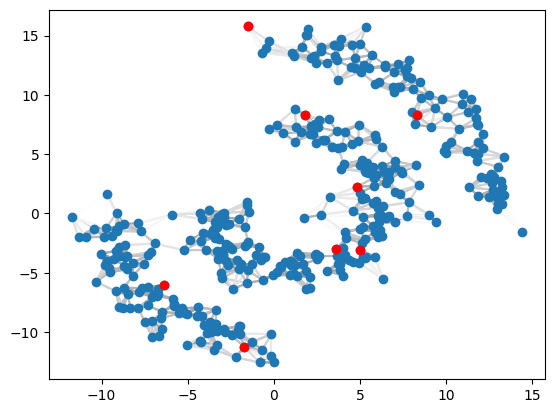

In [340]:
L, W = KNN(X, M, k, rbf)

plt.scatter(xs, ys)
plt.scatter(xs_k, ys_k, color="red")

l1 = [*range(M)] # Shuffle vertices to make plot more even
shuffle(l1)
l2 = [*range(M)]
shuffle(l2)

for i in l1:
	for j in l2:
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = str(1 - 0.5*W[i,j]), zorder = 0)

In [341]:
tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
C_inv = np.linalg.inv(C)

#### Probit Loss

In [342]:
loss = probit

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

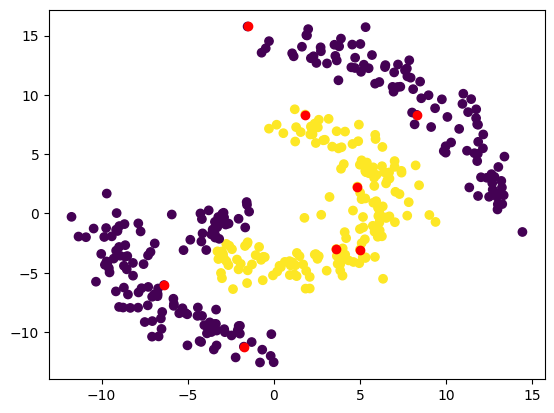

In [343]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [344]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

0.9225


#### Regression Loss

In [345]:
loss = regression

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

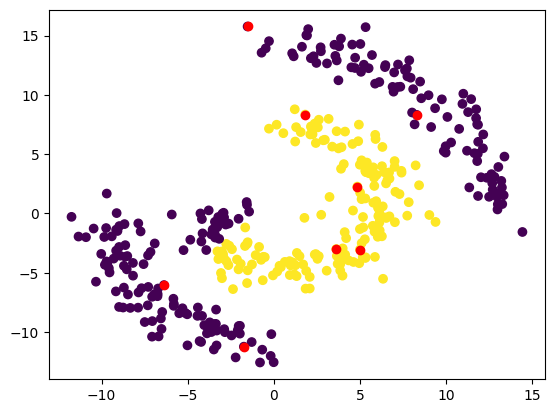

In [346]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [347]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

0.925


This approach does a slightly better job

### Proximity with RBF Kernel

We first need to make a guess at the gamma parameter in the RBF kernel. We use the first quartile of the distances between vertices. Then we adjust using our multplier

In [348]:
dists = []
for x1 in X:
	for x2 in X:
		dists += [dist(x1,x2)]
dists.sort()

mult = 0.05
gamma = dists[floor(len(dists)/4)]*mult

rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

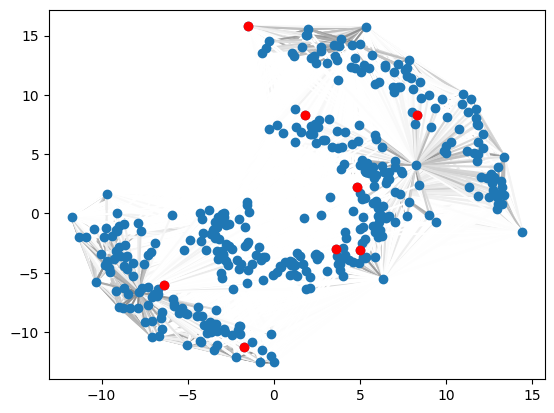

In [349]:
L, W = proximity(X, M, 20, rbf)

plt.scatter(xs, ys)
plt.scatter(xs_k, ys_k, color="red")

l1 = [*range(M)] # Shuffle vertices to make plot more even
shuffle(l1)
l2 = [*range(M)]
shuffle(l2)

for i in l1:
	for j in l2:
		if W[i,j] > 0:
			plt.plot([X[i,0],X[j,0]],[X[i,1],X[j,1]], color = str(1 - 0.5*W[i,j]), zorder = 0)

Now we do the classification

We need to tune the tau parameter here, we want tau^2 to be on the order of epsilon

In [350]:
W2 = np.copy(W)
W2 = W2.flatten()
W2.sort()
tau = W2[floor(3*len(W2)/4)]**(1/2) # 75th percentile of W2 terms

In [351]:
alpha = 2
lamb = (tau**(2*alpha))/2
C = np.linalg.matrix_power(((L + (tau**2)*np.eye(M))),-alpha)
C_inv = np.linalg.inv(C)

#### Probit Loss

In [352]:
loss = probit

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

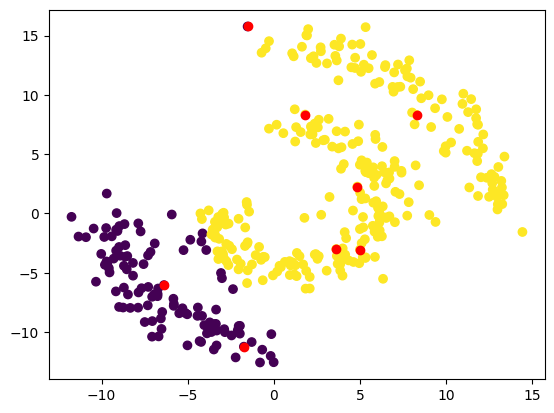

In [353]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [354]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

0.73


### Regression Loss

In [355]:
loss = regression

f0 = np.zeros(M)
result = minimize(to_minimize, f0, args=(knownvals,y,lamb,C_inv,loss), method='BFGS') # Perform minimization

f_star = result.x
y_pred = np.sign(f_star) # Predicted labels

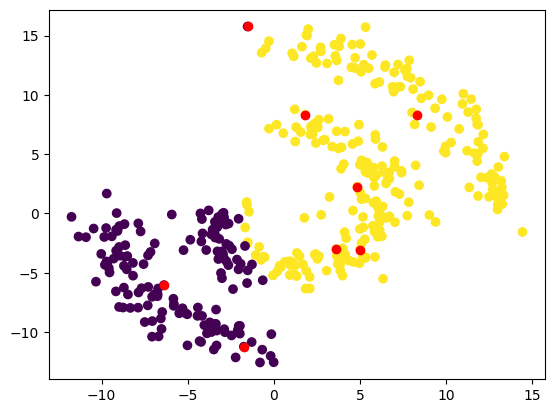

In [356]:
xs = X[:,0]
ys = X[:,1]

xs_k = [xs[j] for j in knownvals]
ys_k = [ys[j] for j in knownvals]

plt.scatter(xs, ys, c=y_pred, cmap = "viridis")
plt.scatter(xs_k, ys_k, color="red")

In [357]:
accuracy = sum([x[0] == x[1] for x in zip(y_pred,y)])/M
print(accuracy)

0.63


We can see that the full RBF graph was both slower to run, and worse in performance than the KNN graph

## Validation of accuracy with multiple trials

We run this process 50 times for each case to confirm this result

### KNN Graph - Uniform Kernel

In [360]:
M = 400 # Multiple of 4

tranges = np.array([[pi,5*pi/2], [3*pi,7*pi/2], [4*pi,9*pi/2]])
var = 1

k = 5
tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(M, tranges, var)

	sum_acc += KNN_acc(X, y, knownvals, alpha = alpha, tau = tau, lossf = "probit", k = k, kernel = unif)

probit_accuracy = sum_acc/50

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(M, tranges, var)

	sum_acc += KNN_acc(X, y, knownvals, alpha = alpha, tau = tau, lossf = "regression", k = k, kernel = unif)

regression_accuracy = sum_acc/50

100%|██████████| 50/50 [08:51<00:00, 10.62s/it]


In [361]:
print(probit_accuracy)
print(regression_accuracy)

0.9479999999999998
0.93505


### KNN Graph - RBF Kernel

In [362]:
M = 400 # Multiple of 4

tranges = np.array([[pi,5*pi/2], [3*pi,7*pi/2], [4*pi,9*pi/2]])
var = 1

k = 5
tau = 1
alpha = 2
lamb = (tau**(2*alpha))/2

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(M, tranges, var)

	dists = []
	for x1 in X:
		for x2 in X:
			dists += [dist(x1,x2)]
	dists.sort()

	mult = 0.15
	gamma = dists[floor(len(dists)/4)]*mult

	rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

	sum_acc += KNN_acc(X, y, knownvals, alpha = alpha, tau = tau, lossf = "probit", k = k, kernel = rbf)

probit_accuracy = sum_acc/50

sum_acc = 0
for j in tqdm(range(50)):
	X, y, knownvals = clusters(M, tranges, var)

	dists = []
	for x1 in X:
		for x2 in X:
			dists += [dist(x1,x2)]
	dists.sort()

	mult = 0.15
	gamma = dists[floor(len(dists)/4)]*mult

	rbf = lambda x1, x2: np.exp(gamma**2*-0.5*dist(x1,x2)**2)

	sum_acc += KNN_acc(X, y, knownvals, alpha = alpha, tau = tau, lossf = "regression", k = k, kernel = rbf)

regression_accuracy = sum_acc/50

100%|██████████| 50/50 [08:48<00:00, 10.58s/it]


In [363]:
print(probit_accuracy)
print(regression_accuracy)

0.9629999999999999
0.95765


We can see that with the choices made above, both the disconnected and O(Eps) graphs classify the data with 100% accuracy